In [1]:
import timeit
import psutil
import sys
import os
import matplotlib.pyplot as plt

from multiprocessing import cpu_count
from concurrent.futures import ProcessPoolExecutor as Pool

In [2]:
def measure_runtime_and_memory(func, params, array):
    memory_before = psutil.virtual_memory()[3] / 1024 # in KB
    start_time = timeit.default_timer()
    func(array, **params)
    end_time = timeit.default_timer()
    memory_after = psutil.virtual_memory()[3] / 1024
    memory_usage = memory_after - memory_before
    runtime = end_time - start_time
    return runtime, memory_usage

Use multiprocessing to run sorts fast

In [3]:
def run_tests_float(sort_functions, funcs_params, input_sizes, input_range,
                    executor=Pool):
    data = {label: [] for _, label in sort_functions}
    with executor(max_workers=cpu_count()) as pool:
        for sort_func, label in sort_functions:
            for size in input_sizes:
                array = random_1_dim_array(
                    elts_range=input_range, size_of_1_dim_range=size)
                data[label].append(pool.submit(
                    measure_runtime_and_memory, sort_func,
                    funcs_params[str(sort_func.__name__)],
                    array))
        for sort_func, label in sort_functions:
            for i in range(len(data[label])):
                data[label][i] = data[label][i].result()
    return data

In [28]:
def plot_results(data_to_plot):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()

    for label in data_to_plot:
        ax1.plot([i[0] for i in input_sizes], [sum([runtime for runtime, memory in i])/len([runtime for runtime, memory in i]) \
                                           for i in data_to_plot[label]], marker='o', label=f'{label} (Runtime)')
        ax2.plot([i[0] for i in input_sizes], [sum([memory for runtime, memory in i])/len([memory for runtime, memory in i]) \
                                           for i in data_to_plot[label]], marker='x', label=f'{label} (Memory)')

    ax1.set_xlabel('Input Size')
    ax1.set_ylabel('Runtime (seconds)')
    ax2.set_ylabel('Memory (KB)')
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    fig.legend(loc='upper right')
    plt.grid(True)
    plt.title('Sorting Algorithms Runtimes and Memory Consumption')
    plt.show()

Import written sorts

In [5]:
os.chdir('../../../')
sys.path.append(os.getcwd())


from Algorithms.python_solutions.quick_sort import quick_sort
from Algorithms.python_solutions.merge_sort import merge_sort
from Algorithms.python_solutions.insert_sort import insert_sort
from Algorithms.python_solutions.heap import heap_sort
from Algorithms.python_solutions.tests.test_sorts_and_searches import random_1_dim_array

Stress tests for the research objectives will be divided into 3 parts (by the amount of elements in the sample arrays): 
- start of the curves (up to 1k elements);
- transition part I (1k to 10k elements);
- transition part II (10k to 1kk elements);
- asymptotic part (1kk and 5kk).

Going further is quite a challenge since even a 1kkk elements array would require (a 64-bit system, python's float is 24 bytes) 24 GBs, and anything more than 5kk in size would need at least 15 sec for my algorithms to run, which, multiplied by 10 for statistical purposes, is a lot of time.

In [6]:
input_sizes = [(1, 1), (5, 5), (10, 10), (50, 50), (100, 100), (500, 500), (1000, 1000)]

sorting_algorithms = [
    (heap_sort, 'Heap Sort'),
    (insert_sort, 'Insertion Sort'),
    (quick_sort, 'Quick Sort'),
    (merge_sort, 'Merge Sort')
]

funcs_params = {
    'heap_sort': {},
    'insert_sort': {},
    'quick_sort': {},
    'merge_sort': {}
}

input_range = (-100, 100)

Everything will be tested for 10 times to get some statistics and remove uncertainty

In [7]:
full_data = []
for _ in range(10):
    one_test_data = run_tests_float(sorting_algorithms, funcs_params, input_sizes, input_range)
    full_data.append(one_test_data)

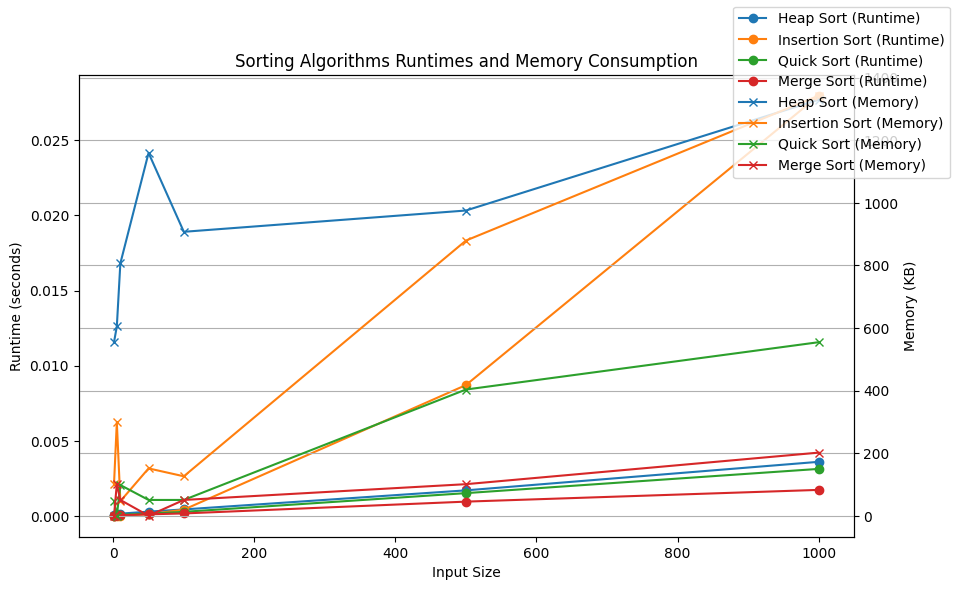

In [8]:
data_to_plot = {label: [[full_data[i][label][j] for i in range(10)] for j in range(len(input_sizes))] for _, label in sorting_algorithms}
plot_results(data_to_plot)

It is clear that while heap, merge and quick sorts have somewhat logarithmic or square root curves, insertion sort certainly has a quadratic one. Memories required do not give any valuable information for now, since all jumps at the very start can be explained by how python allocates memory.

Important notice! While insertion sort seems to be the worst, when there are fewer than 100 elements it might be better. We will get back to this point when the comparison is done.

In [9]:
input_sizes = [(1000, 1000), (5000, 5000), (10000, 10000)]

sorting_algorithms = [
    (heap_sort, 'Heap Sort'),
    (insert_sort, 'Insertion Sort'),
    (quick_sort, 'Quick Sort'),
    (merge_sort, 'Merge Sort')
]

funcs_params = {
    'heap_sort': {},
    'insert_sort': {},
    'quick_sort': {},
    'merge_sort': {}
}

In [10]:
full_data = []
for _ in range(10):
    one_test_data = run_tests_float(sorting_algorithms, funcs_params, input_sizes, input_range)
    full_data.append(one_test_data)

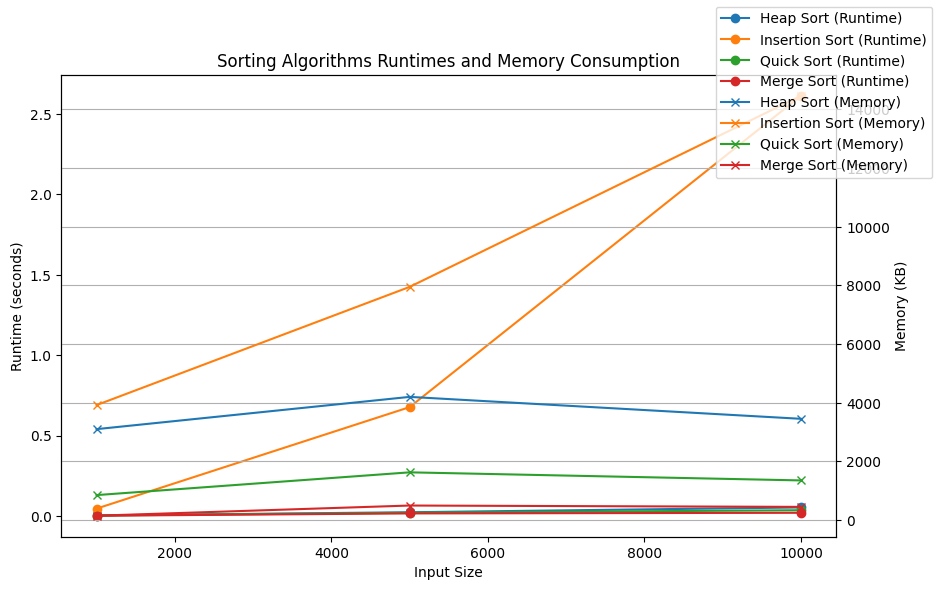

In [11]:
data_to_plot = {label: [[full_data[i][label][j] for i in range(10)] for j in range(len(input_sizes))] for _, label in sorting_algorithms}
plot_results(data_to_plot)

An increase in sample size to 10 times led to an increase of 100 times in time consumption. Quadratic dependency for the time. Let's test its optimized implementation instead, where
- A binary search is used to find the insertion point:
Instead of comparing the current element with each element to its left, using a binary search to find the correct position for the current element will reduce the number of comparisons and swaps.

- The number of swaps minimized:
Minimizing the number of swaps is achieved by keeping the current element in a separate variable and shifting elements to the right while searching for the insertion point until the correct position is found.

In [12]:
from Algorithms.python_solutions.insert_sort import insert_sort_opt

In [13]:
input_sizes = [(1000, 1000), (5000, 5000), (10000, 10000)]

sorting_algorithms = [
    (heap_sort, 'Heap Sort'),
    (insert_sort_opt, 'Insertion Sort'),
    (quick_sort, 'Quick Sort'),
    (merge_sort, 'Merge Sort')
]

funcs_params = {
    'heap_sort': {},
    'insert_sort_opt': {},
    'quick_sort': {},
    'merge_sort': {}
}

In [14]:
full_data = []
for _ in range(10):
    one_test_data = run_tests_float(sorting_algorithms, funcs_params, input_sizes, input_range)
    full_data.append(one_test_data)

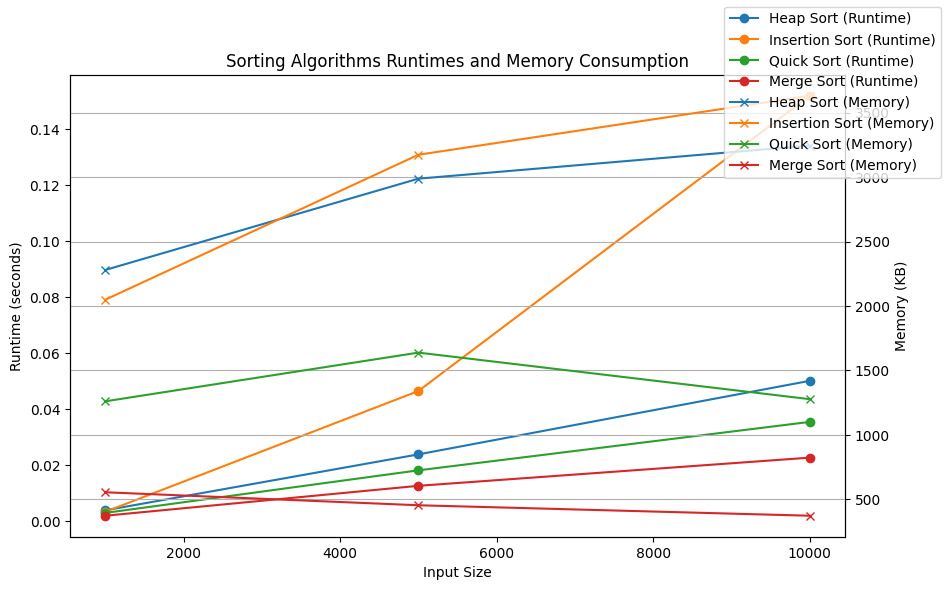

In [15]:
data_to_plot = {label: [[full_data[i][label][j] for i in range(10)] for j in range(len(input_sizes))] for _, label in sorting_algorithms}
plot_results(data_to_plot)

With the new implementation, there is a significant decrease in time consumption (about 15 times!), however, its quadratic time dependency still makes it not even close to the other sorts with the time difference being at least 2.5 times more than others, though not 37 as for before optimization. Further, an increase in the input size would require much more time than a couple of seconds for a single sort hence, insertion sort will be removed from stress tests as ineffective on larger arrays.

Let's now increase input_size.

In [19]:
input_sizes = [(10000, 10000), (50000, 50000), (100000, 100000), (500000, 500000)]

sorting_algorithms = [
    (heap_sort, 'Heap Sort'),
    (quick_sort, 'Quick Sort'),
    (merge_sort, 'Merge Sort')
]

funcs_params = {
    'heap_sort': {},
    'quick_sort': {},
    'merge_sort': {}
}

In [20]:
full_data = []
for _ in range(10):
    one_test_data = run_tests_float(sorting_algorithms, funcs_params, input_sizes, input_range)
    full_data.append(one_test_data)

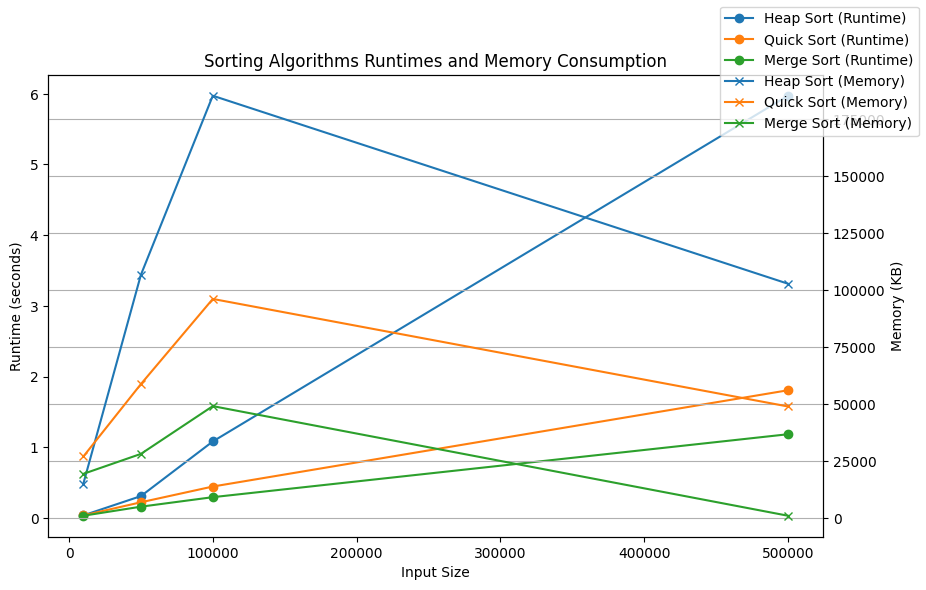

In [21]:
data_to_plot = {label: [[full_data[i][label][j] for i in range(10)] for j in range(len(input_sizes))] for _, label in sorting_algorithms}
plot_results(data_to_plot)

It looks like, time consumption for heap sort now starts to require some time, especially compared to other sorts.

Considering time complexities, heap sort starts to underperform, which can be explained by higher constant factors and less cache-friendly memory allocation patterns than partitioning and merging. It is important to note that heap sort requires a lot of memory for building heap structure when other sorts are done in place.

Because of this, it will be removed from further stress tests.

In [22]:
input_sizes = [(500000, 500000), (1000000, 1000000), (5000000, 5000000)]

sorting_algorithms = [
    (quick_sort, 'Quick Sort'),
    (merge_sort, 'Merge Sort')
]

funcs_params = {
    'quick_sort': {},
    'merge_sort': {}
}

In [23]:
full_data = []
for _ in range(10):
    one_test_data = run_tests_float(sorting_algorithms, funcs_params, input_sizes, input_range)
    full_data.append(one_test_data)

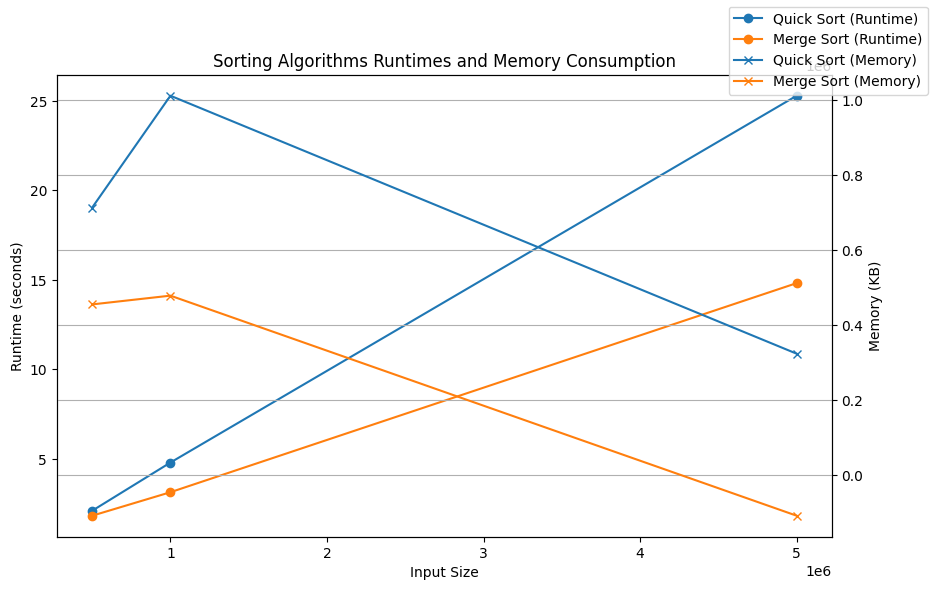

In [24]:
data_to_plot = {label: [[full_data[i][label][j] for i in range(10)] for j in range(len(input_sizes))] for _, label in sorting_algorithms}
plot_results(data_to_plot)

With increase in input_size of 10 times runtime grows a little bit more than in 10 times, which corresponds to O(nlogn) time complexity.

Let's now take the fastest merge_sort and compare its performance to the built-in sorted().

In [25]:
input_sizes = [(1, 1), (5, 5), (10, 10), (50, 50), (100, 100), (500, 500), (1000, 1000),
               (5000, 5000), (10000, 10000), (50000, 50000), (100000, 100000), (500000, 500000), 
               (1000000, 1000000), (5000000, 5000000)]

sorting_algorithms = [
    (sorted, 'Sorted'),
    (merge_sort, 'Merge Sort')
]

funcs_params = {
    'sorted': {},
    'merge_sort': {}
}

In [26]:
full_data = []
for _ in range(10):
    one_test_data = run_tests_float(sorting_algorithms, funcs_params, input_sizes, input_range)
    full_data.append(one_test_data)

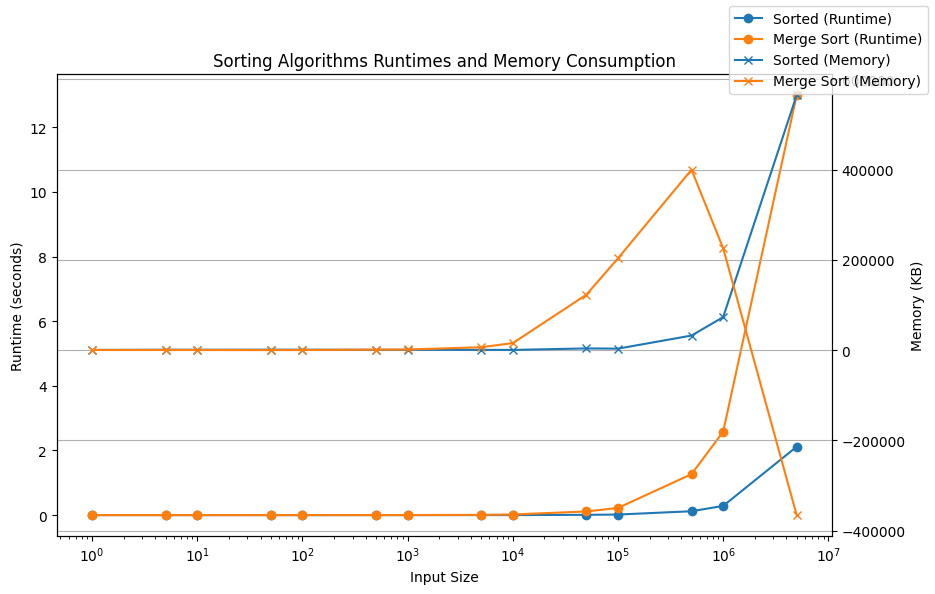

In [29]:
data_to_plot = {label: [[full_data[i][label][j] for i in range(10)] for j in range(len(input_sizes))] for _, label in sorting_algorithms}
plot_results(data_to_plot)